## Intro to Portfolio Risk Management

**Single Asset**<br>
-Mean, Variance and Stand Dev, Skewness, Kurtosis.<br>
-Normality tests.<br>

**Portfolio - Multiple Assets**<br>
-Equal weighted (1/n) and market-cap weighted portfolios.<br>
-Correlation - covariance matrix.<br>
-Portfolio vol / stand dev.<br>
-Max Sharpe and Min Var portfolios (Markowitz).<br>

**Risk Factors**<br>
-Beta and the CAPM.<br>
-Fama French 3-factor model and EMH.<br>
-Other models.<br>

**Simple Risk Metrics**<br>
-Drawdown.<br>
-Historical value at risk.<br>
-Historical expected shortfall.<br>
-Parametric VaR and VaR scaling.<br>
-Simulated VaR: Random walk and Monte Carlo simulation.<br>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import path

 -----------------------------------------------------------------------------------------------------------------------------------------------------------------<br>
### Single asset

In [2]:
msft_prices = pd.read_csv('./assets/qrm_MSFTPrices.csv',index_col='Date')
msft_prices.head()

,Open,High,Low,Close,Volume,Adjusted
Date,,,,,,
2000-01-03,88.777,89.722,84.712,58.28125,53228400,38.527809
2000-01-04,85.893,88.588,84.901,56.31250,54119000,37.226345
2000-01-05,84.050,88.021,82.726,56.90625,64059600,37.618851
2000-01-06,84.853,86.130,81.970,55.00000,54976600,36.358688
2000-01-07,82.159,84.901,81.166,55.71875,62013600,36.833828


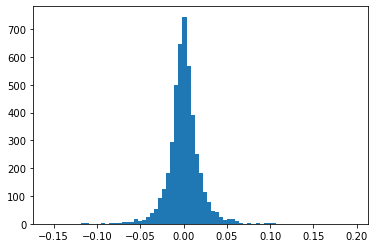

In [3]:
returns_plot = pd.DataFrame(msft_prices['Adjusted'].pct_change())
plt.hist(returns_plot, bins=75)
plt.show()

**First moment: mean**<br>
<math xmlns="http://www.w3.org/1998/Math/MathML" display="block">
  <mtext>Average Annualized Return</mtext>
  <mo>=</mo>
  <mo stretchy="false">(</mo>
  <mo stretchy="false">(</mo>
  <mn>1</mn>
  <mo>+</mo>
  <mi>&#x3BC;</mi>
  <msup>
    <mo stretchy="false">)</mo>
    <mrow>
      <mn>252</mn>
    </mrow>
  </msup>
  <mo stretchy="false">)</mo>
  <mo>&#x2212;</mo>
  <mn>1</mn>
</math>

In [4]:
mean_ann_ret = (((1+np.mean(returns_plot))**252)-1)*100
mean_ann_ret

Adjusted    9.985839
dtype: float64

**Second moment: vol**

In [5]:
volatility_ann = (np.std(returns_plot))*np.sqrt(252)*100
volatility_ann

Adjusted    30.703045
dtype: float64

**The variance is simply σ^2**

In [6]:
variance_ann = (volatility_ann/100)**2*100

display(np.var(returns_plot)*252*100)

variance_ann

Adjusted    9.42677
dtype: float64

Adjusted    9.42677
dtype: float64

**Third moment: skewness**<br>

A negative skew is a right-leaning curve, while positive skew is a left-leaning curve. In finance, you would tend to want positive skewness, as this would mean that the probability of large positive returns is unusually high, and the negative returns are more closely clustered and predictable.

<img src=https://upload.wikimedia.org/wikipedia/commons/thumb/f/f8/Negative_and_positive_skew_diagrams_%28English%29.svg/2880px-Negative_and_positive_skew_diagrams_%28English%29.svg.png>

In [7]:
# Import skew from scipy.stats
from scipy.stats import skew

# Calculate the third moment (skewness) of the returns distribution
returns_skewness = skew(returns_plot.dropna())
print(returns_skewness)

[0.21935459]


**Fourth moment: kurtosis**<br>

A measure of thickness of the tails of the distribution.<br>

Leptokurtic: when a distribution has positive excess kurtosis<br>

This (scipy.kurt) function actually returns the excess kurtosis, not the 4th moment itself. In order to calculate kurtosis, simply add 3 to the excess kurtosis returned by kurtosis().<br>

In [8]:
# Import kurtosis from scipy.stats
from scipy.stats import kurtosis

# Calculate the excess kurtosis of the returns distribution
excess_kurtosis = kurtosis(returns_plot.dropna())
print(excess_kurtosis)

# Derive the true fourth moment of the returns distribution
fourth_moment = excess_kurtosis+3
print(fourth_moment)

[10.31457262]
[13.31457262]


**Normality tests**

You can use the shapiro() function from scipy.stats to run a Shapiro-Wilk test of normality on the stock returns. The function will return two values in a list. The first value is the t-stat of the test, and the second value is the p-value. You can use the p-value to make a judgement about the normality of the data. If the p-value is less than or equal to 0.05, you can safely reject the null hypothesis of normality and assume that the data are non-normally distributed.

In [9]:
# Import shapiro from scipy.stats
from scipy.stats import shapiro

# Run the Shapiro-Wilk test on the stock returns
shapiro_results = shapiro(returns_plot.dropna())
print("Shapiro results:", shapiro_results)

# Extract the p-value from the shapiro_results
p_value = shapiro_results.pvalue
print("P-value: ", p_value)

Shapiro results: ShapiroResult(statistic=0.9003633260726929, pvalue=0.0)
P-value:  0.0


 -----------------------------------------------------------------------------------------------------------------------------------------------------------------<br>
 ### Portfolio of assets

In [10]:
big9 = pd.read_csv('./assets/qrm_Big9Returns2017.csv',index_col='Date')
big9.head()

,AAPL,MSFT,XOM,JNJ,JPM,AMZN,GE,FB,T
Date,,,,,,,,,
2017-01-03,0.002849,0.007081,0.006980,0.005468,0.010894,0.005068,0.002848,0.015732,0.011521
2017-01-04,-0.001119,-0.004474,-0.011002,-0.001640,0.001844,0.004657,0.000316,0.015660,-0.005811
2017-01-05,0.005085,0.000000,-0.014907,0.010463,-0.009205,0.030732,-0.005678,0.016682,-0.002806
2017-01-06,0.011148,0.008668,-0.000565,-0.004792,0.000116,0.019912,0.002855,0.022707,-0.019924
2017-01-09,0.009159,-0.003183,-0.016497,-0.000172,0.000697,0.001168,-0.004745,0.012074,-0.012585


**Calculating portfolio returns**

In [11]:
# Finish defining the portfolio weights as a numpy array
portfolio_weights = np.array([0.12, 0.15, 0.08, 0.05, 0.09, 0.10, 0.11, 0.14, 0.16])

# Calculate the weighted stock returns
WeightedReturns = big9.mul(portfolio_weights, axis=1)

# Calculate the portfolio returns
returns_plot['Portfolio'] = WeightedReturns.sum(axis=1)

**Equally weighted portfolios**<br>
When comparing different portfolios, you often want to consider performance versus a naive equally-weighted portfolio. If the portfolio doesn't outperform a simple equally weighted portfolio, you might want to consider another strategy, or simply opt for the naive approach if all else fails. You can expect equally-weighted portfolios to tend to outperform the market when the largest companies are doing poorly. This is because even tiny companies would have the same weight in your equally-weighted portfolio as Apple or Amazon, for example.

In [12]:
numstocks = 9
eq_weights = [1/numstocks for i in range(numstocks)] # OR use np.repeat(1/numstocks,numstocks)

# Calculate the portfolio returns
returns_plot['EQ_Portfolio'] = big9.mul(eq_weights, axis=1).sum(axis=1)

**Market-cap weighted portfolios**<br>
Conversely, when large companies are doing well, market capitalization, or "market cap" weighted portfolios tend to outperform. This is because the largest weights are being assigned to the largest companies, or the companies with the largest market cap.

In [13]:
# Create an array of market capitalizations (in billions)
market_capitalizations = np.array([601.51, 469.25, 349.5, 310.48, 299.77, 356.94, 268.88, 331.57, 246.09])

# Calculate the market cap weights
mcap_weights = market_capitalizations/market_capitalizations.sum()

returns_plot['MC_Portfolio'] = big9.mul(mcap_weights, axis=1).sum(axis=1)

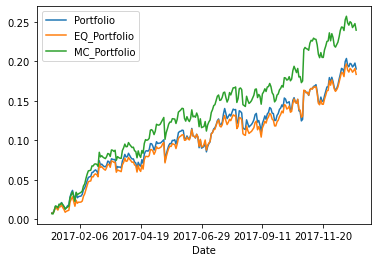

In [14]:
# Plot the cumulative portfolio returns over time
CumulativeReturns = ((1+returns_plot[['Portfolio','EQ_Portfolio','MC_Portfolio']]).cumprod()-1)
CumulativeReturns.plot()
plt.show()

**Correlation and Variance-Covariance Matrix**<br>
The correlation matrix can be used to estimate the linear historical relationship between the returns of multiple assets. You can use the built-in .corr() method on a pandas DataFrame to easily calculate the correlation matrix.

Correlation ranges from -1 to 1. The diagonal of the correlation matrix is always 1, because a stock always has a perfect correlation with itself. The matrix is symmetric, which means that the lower triangle and upper triangle of the matrix are simply reflections of each other since correlation is a bi-directional measurement.

Compute the co-variance matrix of a DataFrame of returns using the .cov() method.

The correlation matrix doesn't really tell you anything about the variance of the underlying assets, only the linear relationships between assets. The co-variance (a.k.a. variance-covariance) matrix, on the other hand, contains all of this information, and is very useful for portfolio optimization and risk management purposes.

/Users/lazaros/opt/anaconda3/lib/python3.8/site-packages/seaborn/matrix.py:298: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  mesh = ax.pcolormesh(self.plot_data, cmap=self.cmap, **kws)


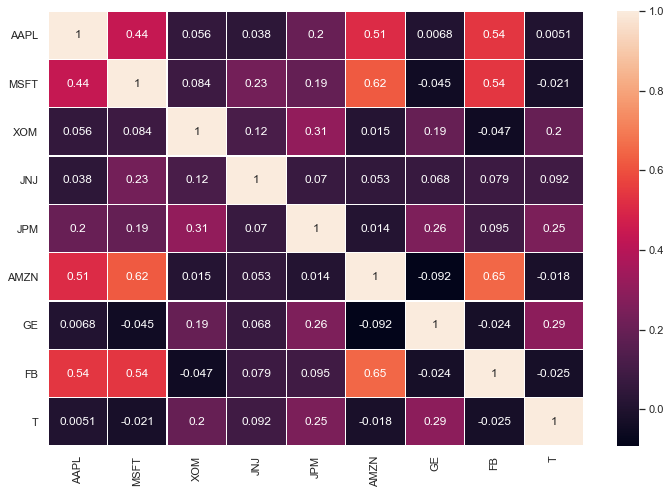

,AAPL,MSFT,XOM,JNJ,JPM,AMZN,GE,FB,T
AAPL,0.030996,0.011400,0.001093,0.000774,0.005716,0.018805,0.000236,0.016243,0.000152
MSFT,0.011400,0.021912,0.001392,0.003899,0.004597,0.019275,-0.001315,0.013682,-0.000530
XOM,0.001093,0.001392,0.012500,0.001548,0.005554,0.000354,0.004295,-0.000890,0.003751
JNJ,0.000774,0.003899,0.001548,0.013092,0.001307,0.001266,0.001540,0.001545,0.001780
JPM,0.005716,0.004597,0.005554,0.001307,0.026371,0.000474,0.008283,0.002631,0.006972
AMZN,0.018805,0.019275,0.000354,0.001266,0.000474,0.043954,-0.003830,0.023290,-0.000638
GE,0.000236,-0.001315,0.004295,0.001540,0.008283,-0.003830,0.039270,-0.000821,0.009849
FB,0.016243,0.013682,-0.000890,0.001545,0.002631,0.023290,-0.000821,0.028937,-0.000708
T,0.000152,-0.000530,0.003751,0.001780,0.006972,-0.000638,0.009849,-0.000708,0.028833


In [37]:
import seaborn as sns

# Correlation matrix heatmap
sns.heatmap(big9.corr(),annot=True,CMAP='YlGnBu',linewidths=0.3,
            annot_kws={"size": 12},)

# Plot aesthetics
sns.set(rc = {'figure.figsize':(12,8)})
plt.xticks(rotation=90)
plt.yticks(rotation=0) 
plt.show()


# Calculate and annualize the co-variance matrix
cov_mat_annual = big9.cov()*252
display(cov_mat_annual)

**Efficient frontier, MSR, GMV Portfolios**<br>
One of the ways to construct the efficient frontier of risk vs return given a set of assets is to randomly generate combinations and plot the characteristics of each portfolio. In this plot, the x-axis is the risk (standard deviation) and the y-axis is the expected return of each portfolio..

The Sharpe ratio is a simple metric of risk adjusted return which was pioneered by William F. Sharpe. Sharpe ratio is useful to determine how much risk is being taken to achieve a certain level of return. In finance, you are always seeking ways to improve your Sharpe ratio, and the measure is very commonly quoted and used to compare investment strategies. The original 1966 Sharpe ratio calculation is quite simple:

S = (R_asset - rf) / σ_asset

Max Sharpe Portfolio (MSR): lies at the apex of the efficient frontier, can be constructed by looking for the portfolio with the highest Sharpe ratio. The MSR portfolio is often quite erratic. Even though the portfolio had a high historical Sharpe ratio, it doesn't guarantee that the portfolio will have a good Sharpe ratio moving forward

Global Minimum Volatility Portfolio (GMV): is the portfolio with the lowest standard deviation (risk) and the highest return for the given risk level. Returns are very hard to predict, but volatilities and correlations tend to be more stable over time. This means the GMV portfolio often outperforms the MSR portfolios out of sample even though the MSR would outperform quite significantly in-sample. Of course, out of sample results are what really matters in finance.

In [43]:
RandomPortfolios = pd.read_csv('./assets/qrm_EfficientFrontierPortfoliosSlim.csv')
display(RandomPortfolios.head())

# Risk free rate
risk_free = 0

# Calculate the Sharpe Ratio for each asset
RandomPortfolios['Sharpe'] = (RandomPortfolios['Returns'] - risk_free)/RandomPortfolios['Volatility']

# Print the range of Sharpe ratios
print(RandomPortfolios['Sharpe'].describe()[['min', 'max']])

,AAPL weight,MSFT weight,XOM weight,JNJ weight,JPM weight,AMZN weight,GE weight,FB weight,T weight,Returns,Volatility
0,0.000053,0.263110,0.007022,0.040087,0.000027,0.024316,0.355899,0.299400,0.010087,0.127453,0.171565
1,0.042360,0.034922,0.079355,0.043057,0.001435,0.202032,0.225924,0.362324,0.008590,0.138614,0.182723
2,0.207824,0.002132,0.005982,0.041657,0.007498,0.406642,0.064929,0.229260,0.034075,0.155952,0.201185
3,0.096565,0.016775,0.118409,0.037725,0.020013,0.045195,0.512282,0.153015,0.000020,0.118787,0.148958
4,0.131309,0.002733,0.002360,0.047573,0.050633,0.289410,0.313717,0.157123,0.005141,0.138304,0.171473


min    0.742884
max    2.270462
Name: Sharpe, dtype: float64


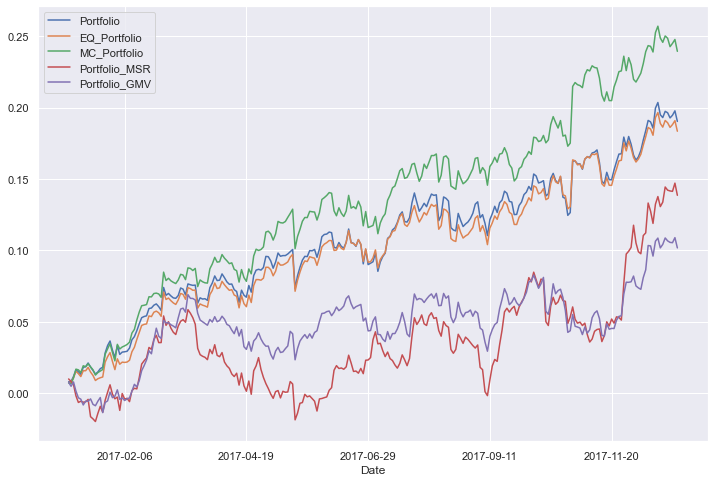

In [49]:
# ----------------------------------------------------------------------------------------------------
# Sort the portfolios by Sharpe ratio
sorted_portfolios = RandomPortfolios.sort_values(by=['Sharpe'], ascending=False)

# Extract the corresponding weights
MSR_weights = sorted_portfolios.iloc[0, 0:numstocks]

# Cast the MSR weights as a numpy array
MSR_weights_array = np.array(MSR_weights)

# Calculate the MSR portfolio returns
returns_plot['Portfolio_MSR'] = big9.iloc[:, 0:numstocks].mul(MSR_weights_array, axis=1).sum(axis=1)

# ----------------------------------------------------------------------------------------------------
# Sort the portfolios by volatility
sorted_portfolios = RandomPortfolios.sort_values(by=['Volatility'], ascending=True)

# Extract the corresponding weights
GMV_weights = sorted_portfolios.iloc[0, 0:numstocks]

# Cast the GMV weights as a numpy array
GMV_weights_array = np.array(GMV_weights)

# Calculate the GMV portfolio returns
returns_plot['Portfolio_GMV'] = big9.iloc[:, 0:numstocks].mul(GMV_weights_array, axis=1).sum(axis=1)

# ----------------------------------------------------------------------------------------------------
# Plot the cumulative returns
CumulativeReturns = ((1+returns_plot[['Portfolio','EQ_Portfolio','MC_Portfolio','Portfolio_MSR','Portfolio_GMV']]).cumprod()-1)
CumulativeReturns.plot()
plt.show()

 -----------------------------------------------------------------------------------------------------------------------------------------------------------------<br>
### Risk Factors

In [50]:
FamaFrenchData = pd.read_csv('./assets/qrm_FamaFrenchFactors.csv')
display(FamaFrenchData.head())

,Date,Portfolio,Market_Excess,SMB,HML,RMW,CMA,RF
0,2013-01-03,-0.005066,-0.0014,0.0014,0.0004,0.0020,0.0023,0.0
1,2013-01-04,0.004024,0.0055,0.0019,0.0043,-0.0037,0.0027,0.0
2,2013-01-07,0.004421,-0.0031,-0.0009,-0.0037,-0.0013,-0.0012,0.0
3,2013-01-08,-0.004659,-0.0027,0.0004,-0.0007,-0.0012,0.0009,0.0
4,2013-01-09,0.004636,0.0034,0.0024,-0.0041,-0.0007,-0.0015,0.0


**Excess returns**<br>
In order to perform a robust analysis on your portfolio returns, you must first subtract the risk-free rate of return from your portfolio returns. The portfolio return minus the risk-free rate of return is known as the Excess Portfolio Return.

In the United States, the risk-free rate has been close to 0 since the financial crisis (2008), but this step is crucial for other countries with higher risk-free rates such as Venezuela or Brazil.

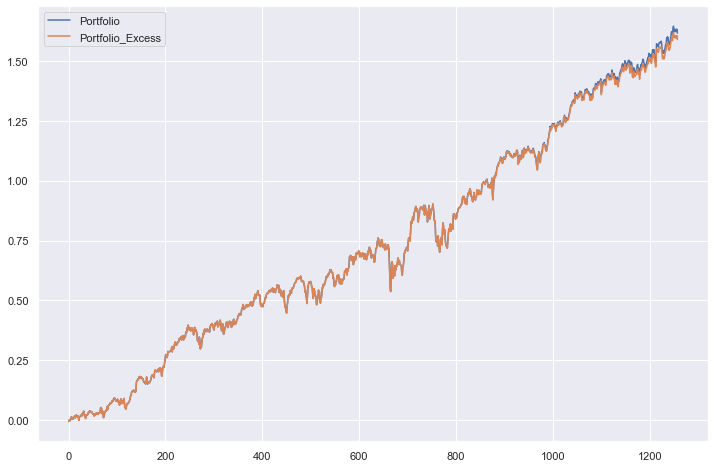

In [51]:
# Calculate excess portfolio returns
FamaFrenchData['Portfolio_Excess'] = FamaFrenchData['Portfolio']-FamaFrenchData['RF']

# Plot returns vs excess returns
CumulativeReturns = ((1+FamaFrenchData[['Portfolio','Portfolio_Excess']]).cumprod()-1)
CumulativeReturns.plot()
plt.show()

**Beta from covariance**<br>
Beta is an essential component of many financial models, and is a measure of systematic risk, or exposure to the broad market. In the CAPM model, beta is one of two essential factors.

Historical beta can be estimated in a number of ways. In this exercise, you will use the following simple formula involving co-variance and variance to a benchmark market portfolio:

beta = Cov(R_portfolio, R_benchmark)/Var(R_benchmark), where benchmark might be the market index.

In [52]:
# Calculate the co-variance matrix between Portfolio_Excess and Market_Excess
covariance_matrix = FamaFrenchData[['Portfolio_Excess', 'Market_Excess']].cov()

# Extract the co-variance co-efficient
covariance_coefficient = covariance_matrix.iloc[0, 1]
print(covariance_coefficient)

# Calculate the benchmark variance
benchmark_variance = FamaFrenchData['Market_Excess'].var()
print(benchmark_variance)

# Calculating the portfolio market beta
portfolio_beta = covariance_coefficient/benchmark_variance
print(portfolio_beta)

5.7261263381549656e-05
5.8803350882118946e-05
0.9737755165745459


**Beta from CAPM**<br>
The expected excess return of a portfolio P equals the expected excess return of the broad market portfolio times the portfolio's beta or exposure to the broad market.

E_R_portfolio - Rf = beta * ( E_R_market - Rf)

In [56]:
# Import statsmodels.formula.api
import statsmodels.formula.api as smf 

# Define the regression formula
CAPM_model = smf.ols(formula = "Portfolio_Excess ~ Market_Excess", data=FamaFrenchData)

# Print adjusted r-squared of the fitted regression
CAPM_fit = CAPM_model.fit()
print(CAPM_fit.rsquared_adj)

# Extract the beta
regression_beta = CAPM_fit.params['Market_Excess']
print(regression_beta)

CAPM_fit.summary()

0.7942627160017839
0.9737755165745459


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Portfolio_Excess   R-squared:                       0.794
Model:                            OLS   Adj. R-squared:                  0.794
Method:                 Least Squares   F-statistic:                     4854.
Date:                Tue, 12 Oct 2021   Prob (F-statistic):               0.00
Time:                        20:20:37   Log-Likelihood:                 5226.5
No. Observations:                1258   AIC:                        -1.045e+04
Df Residuals:                    1256   BIC:                        -1.044e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.0002      0.000      2.009      0.045    5.03e-06       0.000
Market_Excess     0.9738      0.014     69.669      0.000       0.946       1.001
==============================================================================
Omnibus:                      372.020   Durbin-Watson:                   1.965
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3087.179
Skew:                           1.128   Prob(JB):                         0.00
Kurtosis:                      10.335   Cond. No.                         130.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**FF 3-factor model**<br>
The model adds two additional factor to the CAPM, namely the Small minus Big companies expected excess return and the High minus Low value expected excess return:

E_R_portfolio - Rf = beta_market * ( E_R_market - Rf) + beta_smb * (SMB) + beta_hml * (HML)

In the Fama-French factor model:

The HML factor is constructed by calculating the return of growth stocks, or stocks with high valuations, versus the return of value stocks.
The SMB factor is constructed by calculating the return of small-cap stocks, or stocks with small market capitalizations, versus the return of large-cap stocks.

In [57]:
# Define the regression formula
FamaFrench_model = smf.ols(formula='Portfolio_Excess ~ Market_Excess + SMB + HML', data=FamaFrenchData)

# Fit the regression
FamaFrench_fit = FamaFrench_model.fit()

# Extract the adjusted r-squared
regression_adj_rsq = FamaFrench_fit.rsquared_adj
print(regression_adj_rsq)

FamaFrench_fit.summary()

0.8193910088585152


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Portfolio_Excess   R-squared:                       0.820
Model:                            OLS   Adj. R-squared:                  0.819
Method:                 Least Squares   F-statistic:                     1902.
Date:                Tue, 12 Oct 2021   Prob (F-statistic):               0.00
Time:                        20:22:48   Log-Likelihood:                 5309.4
No. Observations:                1258   AIC:                        -1.061e+04
Df Residuals:                    1254   BIC:                        -1.059e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.0002      0.000      1.820      0.069   -1.43e-05       0.000
Market_Excess     1.0155      0.014     75.192      0.000       0.989       1.042
SMB              -0.2622      0.021    -12.432      0.000      -0.304      -0.221
HML              -0.1087      0.021     -5.065      0.000      -0.151      -0.067
==============================================================================
Omnibus:                      433.585   Durbin-Watson:                   2.016
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4429.287
Skew:                           1.293   Prob(JB):                         0.00
Kurtosis:                      11.821   Cond. No.                         217.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Gauge significance based on p-values**<br>
Normally, p-values less than 0.05 are considered statistically significant.<br>
Coefficients can be extracted from the fitted regression object using the .params attribute.

In [58]:
# Extract the p-value of the SMB factor
smb_pval = FamaFrench_fit.pvalues['SMB']

# If the p-value is significant, print significant
if smb_pval < 0.05:
    significant_msg = 'significant'
else:
    significant_msg = 'not significant'

# Print the SMB coefficient
smb_coeff = FamaFrench_fit.params['SMB']
print("The SMB coefficient is ", smb_coeff, " and is ", significant_msg)

The SMB coefficient is  -0.2621515274319265  and is  significant


**Alpha**<br>
The alpha (α) left over by the regression is unexplained performance due to unknown factors. In a regression model, this is simply the coefficient of the intercept.

There are two general schools of thought as to why:

-The model simply needs to be expanded. When you have found all of the missing economic factors, you can explain all stock and portfolio returns. This is known as the Efficient Market Hypothesis.<br>

-There is a degree of unexplainable performance that no model will ever capture reliably. Perhaps it is due to skill, timing, intuition or luck, but investors should seek to maximize their alpha.

In [61]:
# Calculate your portfolio alpha
portfolio_alpha = FamaFrench_fit.params['Intercept']
print(portfolio_alpha)

# Annualize your portfolio alpha
portfolio_alpha_annualized = ((1+portfolio_alpha) ** 252) - 1
print(portfolio_alpha_annualized)

0.00018326665203183018
0.04726181730280854


**The 5-factor model**<br>
In 2015, Fama and French extended their previous 3-factor model, adding two additional factors:<br>

RMW: Profitability<br>
CMA: Investment<br>

The RMW factor represents the returns of companies with high operating profitability versus those with low operating profitability, and the CMA factor represents the returns of companies with aggressive investments versus those who are more conservative.

In [63]:
# Define the regression formula
FamaFrench5_model = smf.ols(formula='Portfolio_Excess ~ Market_Excess + SMB + HML + RMW + CMA',
                            data=FamaFrenchData)

# Fit the regression
FamaFrench5_fit = FamaFrench5_model.fit()

# Extract the adjusted r-squared
regression_adj_rsq = FamaFrench5_fit.rsquared_adj
print(regression_adj_rsq)

FamaFrench5_fit.summary()

0.8367245019225793


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Portfolio_Excess   R-squared:                       0.837
Model:                            OLS   Adj. R-squared:                  0.837
Method:                 Least Squares   F-statistic:                     1289.
Date:                Tue, 12 Oct 2021   Prob (F-statistic):               0.00
Time:                        20:31:11   Log-Likelihood:                 5373.9
No. Observations:                1258   AIC:                        -1.074e+04
Df Residuals:                    1252   BIC:                        -1.070e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.0002   9.58e-05      1.819      0.069   -1.37e-05       0.000
Market_Excess     0.9728      0.014     71.773      0.000       0.946       0.999
SMB              -0.2739      0.021    -13.049      0.000      -0.315      -0.233
HML               0.0714      0.026      2.727      0.006       0.020       0.123
RMW              -0.0740      0.034     -2.162      0.031      -0.141      -0.007
CMA              -0.4685      0.042    -11.132      0.000      -0.551      -0.386
==============================================================================
Omnibus:                      379.546   Durbin-Watson:                   1.987
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3276.701
Skew:                           1.144   Prob(JB):                         0.00
Kurtosis:                      10.568   Cond. No.                         486.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

 -----------------------------------------------------------------------------------------------------------------------------------------------------------------<br>
 ### Simple Risk Metrics

In [96]:
USO = pd.read_csv('./assets/qrm_USO.csv',index_col='Date')
display(USO.head())

,USO
Date,
2007-01-03,-0.042636
2007-01-04,-0.040688
2007-01-05,0.009285
2007-01-08,-0.007109
2007-01-09,-0.004001


**Drawdown**<br>
The stock market tends to rise over time, but that doesn't mean that you won't have periods of drawdown.

Drawdown can be measured as the percentage loss from the highest cumulative historical point.

In Python, you can use the .accumulate() and .maximum() functions to calculate the running maximum, and the simple formula below to calculate drawdown:

 
Drawdown= (r_cum_at_time_t / r_running_max) - 1

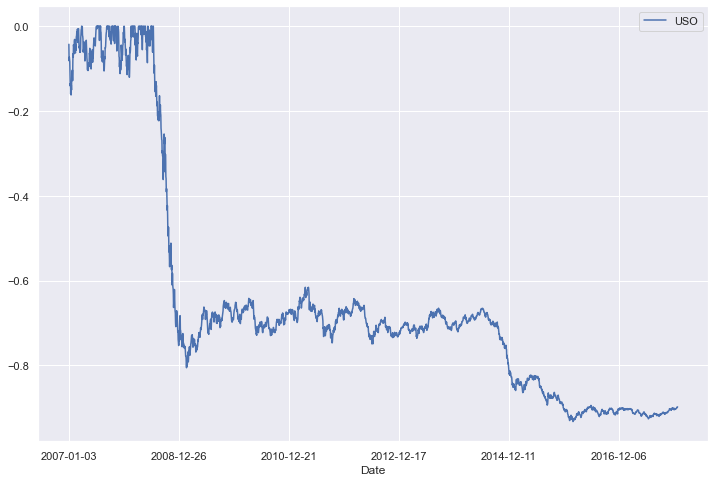

In [85]:
# Calculate the running maximum
cum_rets = (1+USO).cumprod()
running_max = np.maximum.accumulate(cum_rets)

# Ensure the value never drops below 1
running_max[running_max<1] = 1

# Calculate the percentage drawdown
drawdown = (cum_rets)/running_max - 1

# Plot the results
drawdown.plot()
plt.show()

**Historical value at risk**<br>

Drawdown is a measure of sustained losses over time, but what about simple single-day movements?<br>

Value at Risk, often referred to as VaR, is a way to estimate the risk of a single day negative price movement. VaR can be measured for any given probability, or confidence level, but the most commonly quoted tend to be VaR(95) and VaR(99). Historical VaR is the simplest method to calculate VaR, but relies on historical returns data which may not be a good assumption of the future. Historical VaR(95), for example, represents the minimum loss that your portfolio or asset has sustained in the worst 5% of cases.

**Historical expected shortfall**<br>

Expected Shortfall, otherwise known as CVaR, or conditional value at risk, is simply the expected loss of the worst case scenarios of returns.

For example, if your portfolio has a VaR(95) of -3%, then the CVaR(95) would be the average value of all losses exceeding -3%.

-0.03608233764037496
-0.05054143158346778


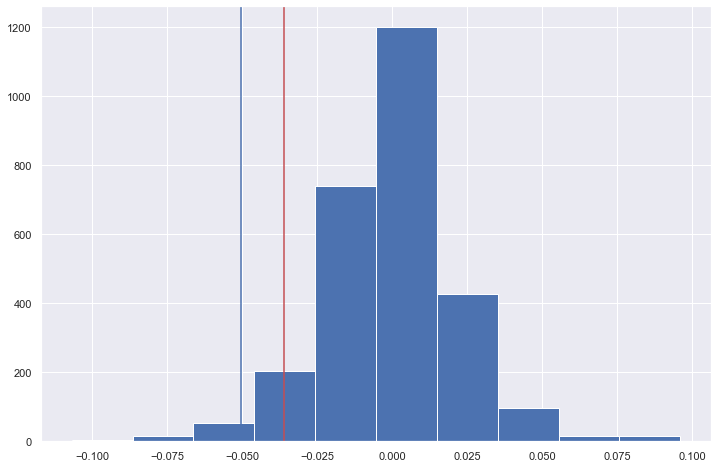

In [127]:
# Calculate historical VaR(95)
var_95 = np.percentile(USO, 5)
print(var_95)

# Historical CVaR 95
cvar_95 = USO[USO <= var_95].mean()[0]
print(cvar_95)

# Sort the returns for plotting
sorted_rets = sorted(np.array(USO).reshape(1,2769)[0])

# Plot the probability of each return quantile
plt.hist(sorted_rets)

# Denote the VaR 95 and CVaR 95 quantiles
plt.axvline(x=var_95, color="r", linestyle="-", label='VaR 95: {0:.2f}%'.format(var_95))
plt.axvline(x=cvar_95, color='b', linestyle='-', label='CVaR 95: {0:.2f}%'.format(cvar_95))
plt.show()

**Parametric value at risk**<br>

Value at Risk can also be computed parametrically using a method known as variance/co-variance VaR. This method allows you to simulate a range of possibilities based on historical return distribution properties rather than actual return values. You can calculate the parametric VaR(90) using:

from scipy.stats import norm<br>
norm.ppf(confidence_level=0.10, mu, vol)<br>

where mu and vol are the mean and volatility, respectively.

In [130]:
# Import norm from scipy.stats
from scipy.stats import norm

# Estimate the average daily return
mu = np.mean(USO.values)

# Estimate the daily volatility
vol = np.std(USO.values)

# Set the VaR confidence level
confidence_level = 0.05

# Calculate Parametric VaR
var_95 = norm.ppf(confidence_level, mu, vol)
print('Mean: ', str(mu), '\nVolatility: ', str(vol), '\nVaR(95): ', str(var_95))

Mean:  -0.00028638956240214787 
Volatility:  0.021888087129708852 
VaR(95):  -0.03628908906473361


**Scaling value at risk**<br>

The VaR(95) number calculated in previous exercises is simply the value at risk for a single day. To estimate the VaR for a longer time horizon, scale the value by the square root of time, similar to scaling volatility:

VaR(95)t_days = VaR(95)1_day * squared_root(t)

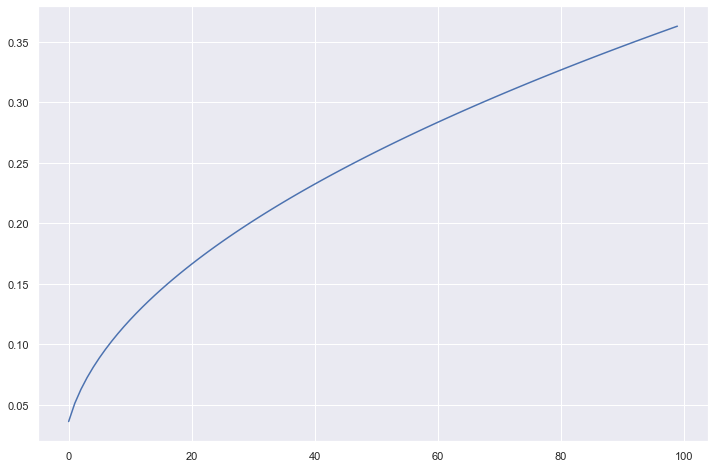

In [143]:
# Aggregate forecasted VaR
forecasted_values = np.empty([100, 2])

# Loop through each forecast period
for i in range(100):
    # Save the time horizon i
    forecasted_values[i, 0] = i
    # Save the forecasted VaR 95
    forecasted_values[i, 1] = -var_95* np.sqrt(1+i)
    
# Plot the results
plt.plot(forecasted_values[:,1])

**Random walk and Monte Carlo simulation**<br>

Stochastic or random movements are used in physics to represent particle and fluid movements, in mathematics to describe fractal behavior, and in finance to describe stock market movements.

Use the np.random.normal() function to model random walk movements of the USO oil ETF with a constant daily average return (mu) and average daily volatility (vol) over the course of T trading days.

Monte-Carlo simulations are used to model a wide range of possibilities.

Monte-Carlos can be constructed in many different ways, but all of them involve generating a large number of random variants of a given model, allowing a wide distribution of possible paths to be analyzed. This can allow you to build a comprehensive forecast of possibilities to sample from without a large amount of historical data.

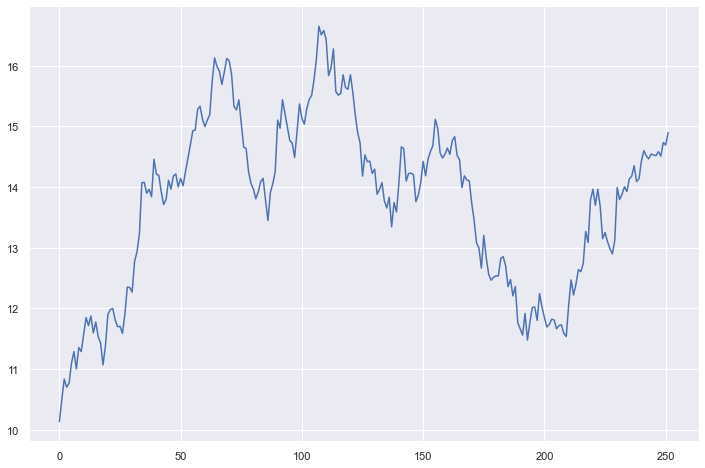

In [144]:
# Set the simulation parameters
mu = np.mean(USO.values)
vol = np.std(USO.values)
T = 252
S0 = 10

# Add one to the random returns
rand_rets = np.random.normal(mu,vol,T) + 1

# Forecasted random walk
forecasted_values = S0 * rand_rets.cumprod()

# Plot the random walk
plt.plot(range(0, T), forecasted_values)
plt.show()

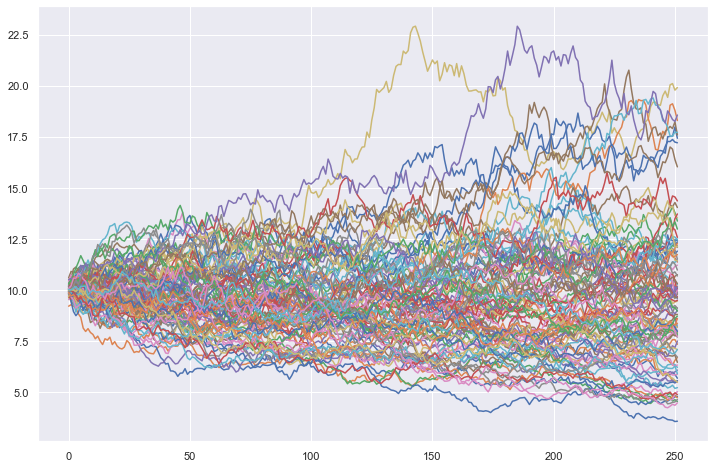

In [145]:
# Loop through 100 simulations
for i in range(100):

    # Generate the random returns
    rand_rets = np.random.normal(mu, vol, T) + 1
    
    # Create the Monte carlo path
    forecasted_values = S0*(rand_rets).cumprod()
    
    # Plot the Monte Carlo path
    plt.plot( range(T),forecasted_values)

# Show the simulations
plt.show()

**Monte Carlo VaR**<br>

Both the return values and the Monte-Carlo paths can be used for analysis of everything ranging from option pricing models and hedging to portfolio optimization and trading strategies.

Aggregate the returns data at each iteration, and use the resulting values to forecast parametric VaR(99).

In [146]:
# Aggregate the returns
sim_returns = []

# Loop through 100 simulations
for i in range(100):

    # Generate the Random Walk
    rand_rets = np.random.normal(mu, vol, T)
    
    # Save the results
    sim_returns.append(rand_rets)

# Calculate the VaR(99)
var_99 = np.percentile(sim_returns,1)
print("Parametric VaR(99): ", round(100*var_99, 2),"%")

Parametric VaR(99):  -5.25 %


 -----------------------------------------------------------------------------------------------------------------------------------------------------------------<br>
 
 
 
 
 

-----------------------------------------------------------------------------------------------------------------------------------------------------------------<br>

## Quant Risk Management

**Modern portfolio theory**<br>
-Efficient frontier and mean/var optimisation.<br>

**Value at risk and Conditional VaR**<br>
-Calculate and interpret VaR and CVaR.<br>

**Portfolio hedging with options**<br>

**Parametric estimation of VaR**<br>
-Goodness of fit vs normal and t-student dist through visualisation.<br>
-Anderson-Darling test.<br>
-Skewness test.<br>

**Historical and Monte Carlo simulation**<br>
-Historical simulation VaR.<br>
-Monte Carlo simulation Var.<br>

**Structural breaks**<br>
-Chow test: null of no structural break | period regression compared with before / after break.<br>

**Extreme value theory**<br>
-Model the tail losses (losses exceeding some value).<br>
-Block maxima.<br>

**Kernel density function**<br>

In [2]:
portfolio = pd.read_csv('./assets/qrm_portfolio.csv')
# Convert the 'Date' column to a datetime index
portfolio['date'] = pd.to_datetime(portfolio['date'], format='%Y/%m/%d')
portfolio.set_index(['date'], inplace = True)

weights = np.repeat(1/4,4)


display(portfolio.head())

,AAPL,AMZN,FB,GOOG,NFLX
date,,,,,
2015-01-02,101.1385,308.52,78.450,524.81,49.8485
2015-01-05,98.2893,302.19,77.190,513.87,47.3114
2015-01-06,98.2985,295.29,76.150,501.96,46.5014
2015-01-07,99.6769,298.42,76.150,501.10,46.7428
2015-01-08,103.5067,300.46,78.175,502.68,47.7792


In [3]:
returns = portfolio.pct_change()

# Convert daily returns to quarterly average returns
returns_q = returns.resample('Q').mean()

# Examine the beginning of the quarterly series
print(returns_q.head())

# Now convert daily returns to weekly minimum returns
returns_w = returns.resample('W').min()

# Examine the beginning of the weekly series
print(returns_w.head())

                AAPL      AMZN        FB      GOOG      NFLX
date                                                        
2015-03-31  0.002375  0.003366  0.000881  0.000821  0.003378
2015-06-30  0.000256  0.002661  0.000758 -0.000759  0.007590
2015-09-30 -0.001708  0.002852  0.000952  0.002826  0.002293
2015-12-31 -0.000544  0.004491  0.002496  0.003572  0.001990
2016-03-31  0.000839 -0.001744  0.001789 -0.000163 -0.001309
                AAPL      AMZN        FB      GOOG      NFLX
date                                                        
2015-01-04       NaN       NaN       NaN       NaN       NaN
2015-01-11 -0.028171 -0.022833 -0.016061 -0.023177 -0.050896
2015-01-18 -0.027140 -0.021550 -0.029234 -0.007296 -0.031766
2015-01-25  0.005161 -0.004471  0.002318 -0.002322  0.021041
2015-02-01 -0.035013 -0.009397 -0.026795 -0.030978 -0.025784


 -----------------------------------------------------------------------------------------------------------------------------------------------------------------<br>
### MPT

Portfolio optimization relies upon an unbiased and efficient estimate of asset covariance. Although sample covariance is unbiased, it is not efficient--extreme events tend to be overweighted.

One approach to alleviate this is through "covariance shrinkage", where large errors are reduced ('shrunk') to improve efficiency. In this exercise, you'll use pypfopt.risk_models's CovarianceShrinkage object to transform sample covariance into an efficient estimate. The textbook error shrinkage method, .ledoit_wolf(), is a method of this object.

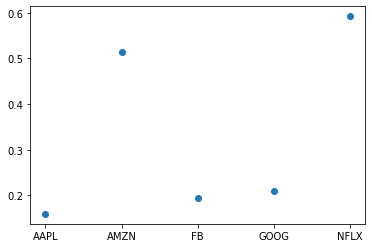

Sample Covariance Matrix
           AAPL      AMZN        FB      GOOG      NFLX
AAPL  0.063118  0.037599  0.032926  0.031483  0.039957
AMZN  0.037599  0.093749  0.049486  0.048395  0.063560
FB    0.032926  0.049486  0.082483  0.041922  0.049808
GOOG  0.031483  0.048395  0.041922  0.057460  0.049559
NFLX  0.039957  0.063560  0.049808  0.049559  0.185543 

Efficient Covariance Matrix
           AAPL      AMZN        FB      GOOG      NFLX
AAPL  0.063731  0.036806  0.032231  0.030819  0.039114
AMZN  0.036806  0.093716  0.048442  0.047374  0.062219
FB    0.032231  0.048442  0.082688  0.041038  0.048757
GOOG  0.030819  0.047374  0.041038  0.058192  0.048513
NFLX  0.039114  0.062219  0.048757  0.048513  0.183573 



In [4]:
# Import the mean_historical_return method
from pypfopt.expected_returns import mean_historical_return

# Import the CovarianceShrinkage object
from pypfopt.risk_models import CovarianceShrinkage

# ----------------------------------------------------------------
# Compute the annualized average historical return
mean_returns = mean_historical_return(portfolio, frequency = 252)

# Plot the annualized average historical return
plt.plot(mean_returns, linestyle = 'None', marker = 'o')
plt.show()

# ----------------------------------------------------------------
# Create the CovarianceShrinkage instance variable
cs = CovarianceShrinkage(portfolio)

# Compute the sample covariance matrix of returns
sample_cov = portfolio.pct_change().cov() * 252

# Compute the efficient covariance matrix of returns
e_cov = cs.ledoit_wolf()

# Display both the sample covariance_matrix and the efficient e_cov estimate
print("Sample Covariance Matrix\n", sample_cov, "\n")
print("Efficient Covariance Matrix\n", e_cov, "\n")

OrderedDict([('AAPL', 0.3991450824944982), ('AMZN', 0.02118367438265307), ('FB', 0.1591331876866899), ('GOOG', 0.4205380554361589), ('NFLX', 0.0)])


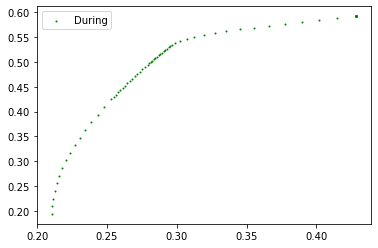

In [5]:
from pypfopt.cla import CLA

# Initialize the Crtical Line Algorithm object
efficient_portfolio = CLA(mean_returns, e_cov)

# Find the minimum volatility portfolio weights and display them
print(efficient_portfolio.min_volatility())

# Compute the efficient frontier
(ret, vol, weights) = efficient_portfolio.efficient_frontier()

# Add the frontier to the plot showing the 'before' and 'after' frontiers
plt.scatter(vol, ret, s = 4, c = 'g', marker = '.', label = 'During')
plt.legend()
plt.show()

-----------------------------------------------------------------------------------------------------------------------------------------------------------------<br>
### VaR and CVaR based on normal distribution
 
The Normal (or Gaussian) distribution is especially appealing as it 1) has an analytically simple form, and 2) represents a wide variety of empirical phenomena. Assume that the loss of a portfolio is normally distributed, i.e., the higher the value drawn from the distribution, the higher the loss.
  
The conditional value at risk (CVaR), or expected shortfall (ES), asks what the average loss will be, conditional upon losses exceeding some threshold at a certain confidence level. It uses VaR as a point of departure, but contains more information because it takes into consideration the tail of the loss distribution.

It's generally the case that CVaR is the preferred risk measure for risk management. One reason is that it is affected by the tail of the loss distribution, while VaR is a static value

95% VaR:  1.6448536269514722 ; 99% VaR:  2.331210540793841


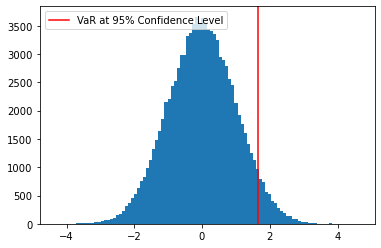

In [6]:
from scipy.stats import norm

# Create the VaR measure at the 95% confidence level using norm.ppf()
VaR_95 = norm.ppf(0.95)

# Create the VaR meaasure at the 5% significance level using numpy.quantile()
draws = norm.rvs(size = 100000)
VaR_99 = np.quantile(draws, 0.99)

# Compare the 95% and 99% VaR
print("95% VaR: ", VaR_95, "; 99% VaR: ", VaR_99)

# Plot the normal distribution histogram and 95% VaR measure
plt.hist(draws, bins = 100)
plt.axvline(x = VaR_95, c='r', label = "VaR at 95% Confidence Level")
plt.legend(); plt.show()

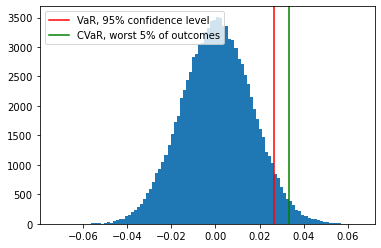

In [7]:
# Apple's returns
portfolio_losses = portfolio.AAPL.pct_change().dropna()

# Compute the mean and variance of the portfolio returns
pm = portfolio_losses.mean()
ps = portfolio_losses.std()

# Compute the 95% VaR using the .ppf()
VaR_95 = norm.ppf(0.95, loc = pm, scale = ps)
# Compute the expected tail loss and the CVaR in the worst 5% of cases
tail_loss = norm.expect(lambda x: x, loc = pm, scale = ps, lb = VaR_95)
CVaR_95 = (1 / (1 - 0.95)) * tail_loss

# Plot the normal distribution histogram and add lines for the VaR and CVaR
plt.hist(norm.rvs(size = 100000, loc = pm, scale = ps), bins = 100)
plt.axvline(x = VaR_95, c='r', label = "VaR, 95% confidence level")
plt.axvline(x = CVaR_95, c='g', label = "CVaR, worst 5% of outcomes")
plt.legend(); plt.show()

-----------------------------------------------------------------------------------------------------------------------------------------------------------------<br>
### VaR and CVaR based on Student's t-distribution

Another common loss distribution, the Student's t-distribution (or T) is contained in scipy.stats.

Recall that CVaR is the expected value of loss given a minimum loss threshold. So CVaR is already in the form of a risk exposure--it is the sum (or integral) of the probability of loss in the distribution tail multiplied, by the loss amount.

To derive the 99% CVaR first fit a T distribution to portfolio losses, using the t.fit() method. This returns the T distribution parameters p used to find the VaR with the .ppf() method.

Then compute the 99% VaR, since it's used to find the CVaR.

Finally, compute the 99% CVaR measure using the t.expect() method.

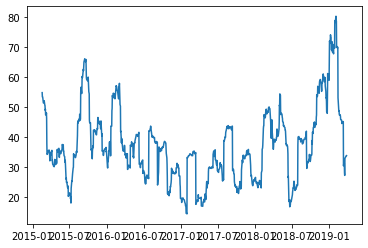

In [8]:
# Import the Student's t-distribution
from scipy.stats import t

# Create rolling window parameter list
mu = portfolio_losses.rolling(30).mean()
sigma = portfolio_losses.rolling(30).std()

rolling_parameters = [(29, mu[i], s) for i,s in enumerate(sigma)]

# Compute the 99% VaR array using the rolling window parameters
VaR_99 = np.array( [ t.ppf(0.99, *params) for params in rolling_parameters ] )

# Plot the minimum risk exposure over the 2005-2010 time period
plt.plot(portfolio_losses.index, 0.01 * VaR_99 * 100000)
plt.show()

In [9]:
# Fit the Student's t distribution to crisis losses
p = t.fit(portfolio_losses)

# Compute the VaR_99 for the fitted distribution
VaR_99 = t.ppf(0.99, *p)

# Use the fitted parameters and VaR_99 to compute CVaR_99
tail_loss = t.expect(lambda y: y, args = (p[0],), loc = p[1], scale = p[2], lb = VaR_99 )
CVaR_99 = (1 / (1 - 0.99)) * tail_loss
print(CVaR_99)

0.07233944130805448


-----------------------------------------------------------------------------------------------------------------------------------------------------------------<br>
### VaR from a fitted distribution

Minimizing CVaR requires calculating the VaR at a confidence level, say 95%. Previously the VaR was derived as a quantile from a Normal (or Gaussian) distribution, but minimizing the CVaR more generally requires computing the quantile from a distribution that best fits the data.

First plot this fitted distribution using its .evaluate() method.

Next use the .resample() method of the fitted object to draw a random sample of 100,000 observations from the fitted distribution.

Finally, using np.quantile() on the random sample compute the 95% VaR.

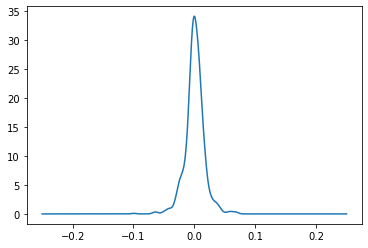

0.025796513726945674


In [10]:
from scipy import stats

fitted = stats.gaussian_kde(portfolio_losses)

# Visualize the fitted distribution with a plot
x = np.linspace(-0.25,0.25,1000)
plt.plot(x,fitted.evaluate(x))
plt.show()

# Create a random sample of 100,000 observations from the fitted distribution
sample = fitted.resample(100000)

# Compute and display the 95% VaR from the random sample
VaR_95 = np.quantile(sample, 0.95)
print(VaR_95)

In [11]:
# Import the EfficientFrontier class
from pypfopt.efficient_frontier import EfficientFrontier

# Import the negative_cvar objective function
# from pypfopt.objective_functions import -> not available in v 1.4.2

# Create the efficient frontier instance
ef = EfficientFrontier(None, e_cov)

# Find the cVar-minimizing portfolio weights at the default 95% confidence level
# optimal_weights = ef.custom_objective(negative_cvar, returns)

# # Display the optimal weights
# print(optimal_weights)

-----------------------------------------------------------------------------------------------------------------------------------------------------------------<br>
### Black-Scholes options pricing

In [12]:
import assets.black_scholes as bs

In [13]:
GOOG_returns = portfolio.GOOG.pct_change().dropna()

# Compute the volatility as the annualized standard deviation of IBM returns
sigma = np.sqrt(252) * GOOG_returns.std()

# Compute the Black-Scholes option price for this volatility
value_s = bs.black_scholes(S = 90, X = 80, T = 0.5, r = 0.02, 
                        sigma = sigma, option_type = "call")

# Compute the Black-Scholes option price for twice the volatility
value_2s = bs.black_scholes(S = 90, X = 80, T = 0.5, r = 0.02, 
                sigma = 2*sigma, option_type = "call")

# Display and compare both values
print("Option value for sigma: ", value_s,
      "\n",
      "Option value for 2 * sigma: ", value_2s)

Option value for sigma:  12.65665821951874 
 Option value for 2 * sigma:  17.57562554793587


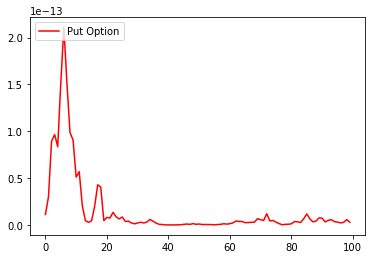

In [14]:
# Select the first 100 observations of IBM data
GOOG_spot = portfolio.GOOG[:100]

# Initialize the European put option values array
option_values = np.zeros(GOOG_spot.size)

# Iterate through IBM's spot price and compute the option values
for i,S in enumerate(GOOG_spot.values):
    option_values[i] = bs.black_scholes(S = S, X = 140, T = 0.5, r = 0.02, 
                        sigma = sigma, option_type = "put")

# Display the option values array
plt.plot(option_values, color = "red", label = "Put Option")
plt.legend(loc = "upper left")
plt.show()

-----------------------------------------------------------------------------------------------------------------------------------------------------------------<br>
### Using options for hedging

Suppose that you have an investment portfolio with one asset, GOOG. You'll hedge the portfolio's risk using delta hedging with a European put option on GOOG.

First, value the European put option using the Black-Scholes option pricing formula, with a strike X of 80 and a time to maturity T of 1/2 a year. The risk-free interest rate is 2% and the spot S is initially 70.

Then create a delta hedge by computing the delta of the option with the bs_delta() function, and use it to hedge against a change in the stock price to 69.5. The result is a delta neutral portfolio of both the option and the stock.

In [15]:
# Compute the annualized standard deviation of returns
sigma = np.sqrt(252) * GOOG_returns.std()

# Compute the Black-Scholes value at spot price 70
value = bs.black_scholes(S = 70, X = 80, T = 0.5, r = 0.02, 
                      sigma = sigma, option_type = "put")

# Find the delta of the option at spot price 70
delta = bs.bs_delta(S = 70, X = 80, T = 0.5, r = 0.02, 
                 sigma = sigma, option_type = "put")

# Find the option value change when the price of falls to 69.5
value_change = bs.black_scholes(S = 69.5, X = 80, T = 0.5, r = 0.02, 
                             sigma = sigma, option_type = "put") - value

print( (69.5 - 70) + (1/delta) * value_change )

0.0045830559124924175


-----------------------------------------------------------------------------------------------------------------------------------------------------------------<br>
### Parameter estimation: Normal

Parameter estimation is the strongest method of VaR estimation because it assumes that the loss distribution class is known. Parameters are estimated to fit data to this distribution, and statistical inference is then made.

Is a Normal distribution a good fit? Test this with the scipy.stats.anderson Anderson-Darling test. If the test result is statistically different from zero, this indicates the data is not Normally distributed.

### Parameter estimation: Skewed Normal

Test the data using the skewtest() function from scipy.stats. If the test result is statistically different from zero, then the data support a skewed distribution.

Parametrically estimate the 95% VaR of a loss distribution fit using scipy.stats's skewnorm skewed Normal distribution. This is a more general distribution than the Normal and allows losses to be non-symmetrically distributed. We might expect losses to be skewed during the crisis, when portfolio losses were more likely than gains.

In [16]:
# Import the Normal distribution and skewness test from scipy.stats
from scipy.stats import norm, anderson

# Fit portfolio losses to the Normal distribution
params = norm.fit(GOOG_returns)

# Compute the 95% VaR from the fitted distribution, using parameter estimates
VaR_95 = norm.ppf(0.95, *params)
print("VaR_95, Normal distribution: ", VaR_95)

# Test the data for Normality
print('')
print("Anderson-Darling test result: ", anderson(GOOG_returns))

VaR_95, Normal distribution:  0.025693606412112994

Anderson-Darling test result:  AndersonResult(statistic=14.582337086268126, critical_values=array([0.574, 0.654, 0.784, 0.915, 1.088]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))


In [17]:
# Import the skew-normal distribution and skewness test from scipy.stats
from scipy.stats import skewnorm, skewtest

# Test the data for skewness
print("Skewtest result: ", skewtest(GOOG_returns))

# Fit the portfolio loss data to the skew-normal distribution
params = skewnorm.fit(GOOG_returns)

# Compute the 95% VaR from the fitted distribution, using parameter estimates
VaR_95 = skewnorm.ppf(0.95, *params)
print('')
print("VaR_95 from skew-normal: ", VaR_95)

Skewtest result:  SkewtestResult(statistic=12.370787690977263, pvalue=3.761147343797354e-35)

VaR_95 from skew-normal:  0.02643647981938545


-----------------------------------------------------------------------------------------------------------------------------------------------------------------<br>
### Historical and Monte Carlo simulation VaR

-Historical VaR: assumes past returns reflect the future ones (no major changes - stable over time).

-Monte Carlo sim VaR: assumes distribution of losses and generates random draws from that distribution to create random paths (runs). VaR is the quantile of these losses across all paths.

In [18]:
hist_var = np.quantile(GOOG_returns,0.05)
hist_var

-0.02317541022587208

In [19]:
from scipy.stats import norm

steps = 1440 # minutes in a day

runs = 10000

mu = GOOG_returns.mean()
sigma = GOOG_returns.std()

daily_loss = np.zeros(runs)

for r in range(runs):
    loss = mu*(1/steps) + norm.rvs(size=steps) * sigma * np.sqrt(1/steps)
    daily_loss[r] = sum(loss)

mc_var = np.quantile(daily_loss,0.05)
mc_var

-0.023947246818531324

-----------------------------------------------------------------------------------------------------------------------------------------------------------------<br>
### Structural breaks: Chow test

https://en.wikipedia.org/wiki/Chow_test

In [20]:
before = GOOG_returns[:500]
after = GOOG_returns[500:]

In [21]:
import statsmodels.api as sm

# Add intercept constants to each sub-period 'before' and 'after'
before_with_intercept = sm.add_constant(before)
after_with_intercept  = sm.add_constant(after)
all_with_intercept = sm.add_constant(GOOG_returns)

# Fit OLS regressions to each sub-period
r_b = sm.OLS(before, before_with_intercept).fit()
r_a = sm.OLS(after,  after_with_intercept).fit()
r_t = sm.OLS(GOOG_returns,  all_with_intercept).fit()

# Get sum-of-squared residuals for both regressions
ssr_before = r_b.ssr
ssr_after = r_a.ssr
ssr_total = r_t.ssr

# Compute and display the Chow test statistic
numerator = ((ssr_total - (ssr_before + ssr_after)) / 2)
denominator = ((ssr_before + ssr_after) / (24 - 4))
print("Chow test statistic: ", numerator / denominator)


Chow test statistic:  -3.8626110506102274


-----------------------------------------------------------------------------------------------------------------------------------------------------------------<br>
### Extreme value theory: Block maxima

https://en.wikipedia.org/wiki/Extreme_value_theory

In [28]:
max_weekly_ret = GOOG_returns.resample('W').max()

max_monthly_ret = GOOG_returns.resample('M').max()

max_quarterly_ret = GOOG_returns.resample('Q').max()

<ipython-input-39-7373d2a8bd3e>:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax_2 = plt.subplot()
<ipython-input-39-7373d2a8bd3e>:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax_3 = plt.subplot()


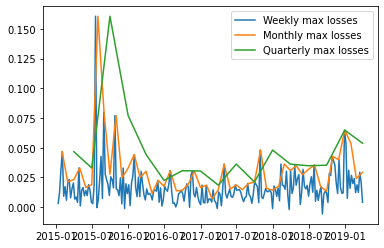

In [39]:
ax_1 = plt.subplot()
ax_1.plot(max_weekly_ret, label = "Weekly max losses")
ax_1.legend()


ax_2 = plt.subplot()
ax_2.plot(max_monthly_ret, label = "Monthly max losses")
ax_2.legend()



ax_3 = plt.subplot()
ax_3.plot(max_quarterly_ret, label = "Quarterly max losses")
ax_3.legend()

plt.figure("")
plt.show()

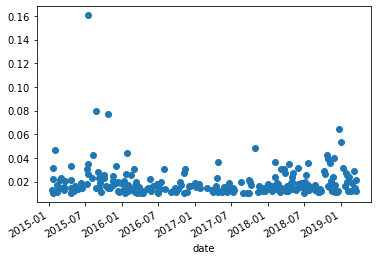

In [43]:
extreme_losses = GOOG_returns[GOOG_returns>0.01]

# Scatter plot the extreme losses
extreme_losses.plot(style='o')
plt.show()

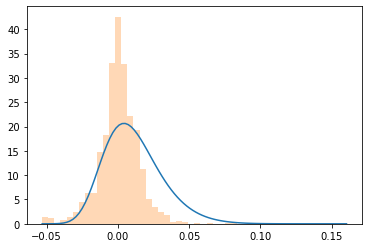

In [50]:
from scipy.stats import genextreme
# Fit extreme distribution to weekly maximum of losses
fitted = genextreme.fit(GOOG_returns)

# Plot extreme distribution with weekly max losses historgram
x = np.linspace(min(GOOG_returns), max(GOOG_returns), 100)
plt.plot(x, genextreme.pdf(x, *fitted))
plt.hist(GOOG_returns, 50, density = True, alpha = 0.3)
plt.show()

In [54]:
# Fit the GEV distribution to the maxima
p = genextreme.fit(-max_weekly_ret)

# Compute the 99% VaR (needed for the CVaR computation)
VaR_99 = genextreme.ppf(0.99, *p)

# Compute the 99% CVaR estimate
CVaR_99 = (1 / (1 - 0.99)) * genextreme.expect(lambda x: x, 
           args=(p[0],), loc = p[1], scale = p[2], lb = VaR_99)

# Display the covering loss amount
print('CVaR: ', CVaR_99)
print("Reserve amount: ", 1000000 * CVaR_99)

CVaR:  0.004894308819499019
Reserve amount:  4894.308819499019


-----------------------------------------------------------------------------------------------------------------------------------------------------------------<br>
### Kernel Density Estimation

KDE of a loss distribution

Kernel density estimation (KDE) can fit distributions with 'fat tails', i.e. distributions with occasionally large deviations from the mean (such as the distribution of portfolio losses).

It's often hard to initially select how to represent a loss distribution. A visual comparison between different fitted distributions is usually a good place to start.

The norm, skewnorm, t, and gaussian_kde distributions might be valid options.

In [94]:
from scipy.stats import gaussian_kde, t

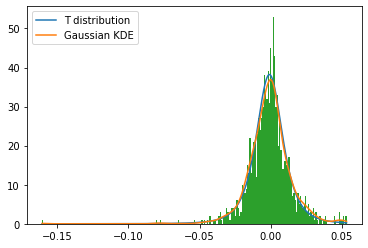

In [95]:
losses = -GOOG_returns

# Generate a fitted T distribution over losses
params = t.fit(losses)

# Generate a Gaussian kernal density estimate over losses
kde = gaussian_kde(losses)

# Add the PDFs of both estimates to a histogram, and display
axis = plt.subplot()
loss_range = np.linspace(np.min(losses), np.max(losses), 1000)
axis.plot(loss_range, t.pdf(loss_range, *params), label = 'T distribution')
axis.plot(loss_range, kde_.pdf(loss_range), label = 'Gaussian KDE')
axis.hist(losses, bins = 235, density = False)
plt.legend()
plt.show()

In [97]:
# Find the VaR as a quantile of random samples from the distributions
VaR_99_T   = np.quantile(t.rvs(size=1000, *p), 0.99)
VaR_99_KDE = np.quantile(kde_.resample(size=1000), 0.99)

# Find the expected tail losses, with lower bounds given by the VaR measures
integral_T   = t.expect(lambda x: x, args = (p[0],), loc = p[1], scale = p[2], lb = VaR_99_T)
# integral_KDE = gaussian_kde.integrate_kde(lambda x: x, lb = VaR_99_KDE)

# Create the 99% CVaR estimates
CVaR_99_T   = (1 / (1 - 0.99)) * integral_T
# CVaR_99_KDE = (1 / (1 - 0.99)) * integral_KDE

# Display the results
print("99% CVaR for T: ", CVaR_99_T,)# "; 99% CVaR for KDE: ", CVaR_99_KDE)

99% CVaR for T:  -5.980732147473716
